In [2]:
# Imports and GPU Configuration
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, applications, regularizers, callbacks
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
# File Paths and Data Processing
train_folder = r"C:\Users\nikhi\Desktop\archive\dataset\drive\MyDrive\lungcancer\data\tfrecords\train"
test_folder = r"C:\Users\nikhi\Desktop\archive\dataset\drive\MyDrive\lungcancer\data\tfrecords\test"
eval_folder = r"C:\Users\nikhi\Desktop\archive\dataset\drive\MyDrive\lungcancer\data\tfrecords\eval"

def parse_tfrecord_fn(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.per_image_standardization(image)
    label = tf.cast(example['label'], tf.int32)
    return image, label

def load_dataset(folder):
    tfrecord_files = tf.data.Dataset.list_files(os.path.join(folder, '*.tfrecord'))
    dataset = tf.data.TFRecordDataset(tfrecord_files, num_parallel_reads=tf.data.AUTOTUNE)
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

In [4]:
# Data Augmentation and Configuration
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1),
    layers.GaussianNoise(0.01)
], name='data_augmentation')

# Load datasets
train_dataset = load_dataset(train_folder)
test_dataset = load_dataset(test_folder)
eval_dataset = load_dataset(eval_folder)

# Training Configuration
BATCH_SIZE = 32
BUFFER_SIZE = 1000
EPOCHS = 50
INITIAL_LR = 5e-5
MIN_LR = 1e-7

In [5]:
# Model Definition
def create_model(input_shape=(224, 224, 3), num_classes=4):
    base_model = applications.EfficientNetB2(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    base_model.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False
        
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization(momentum=0.95)(x)
    x = layers.Dense(512, kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization(momentum=0.95)(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization(momentum=0.95)(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return models.Model(inputs=inputs, outputs=outputs)

In [6]:
# Load the saved model
model = create_model()
model.load_weights('lung_cancer_model_fold_1.h5')  # Load your saved model checkpoint

# Prepare datasets
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = eval_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Calculate class weights
labels = np.array([label.numpy() for _, label in train_dataset.unbatch()])
class_counts = np.bincount(labels)
total_samples = np.sum(class_counts)
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}

# Compile model
optimizer = optimizers.AdamW(
    learning_rate=INITIAL_LR,
    weight_decay=0.001,
    clipnorm=1.0
)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

C:\Users\nikhi\AppData\Local\Temp\ipykernel_15860\1994755997.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}


In [7]:
# Callbacks
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=MIN_LR,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )
]

# Train model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks_list,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/50
    288/Unknown - 469s 2s/step - loss: 1.0735 - accuracy: 0.5593
Epoch 1: val_loss improved from inf to 1.55566, saving model to best_model.h5


C:\Users\nikhi\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


288/288 [==============================] - 663s 2s/step - loss: 1.0735 - accuracy: 0.5593 - val_loss: 1.5557 - val_accuracy: 0.6457 - lr: 5.0000e-05
Epoch 2/50
288/288 [==============================] - ETA: 0s - loss: 1.0473 - accuracy: 0.5418
Epoch 2: val_loss improved from 1.55566 to 1.47112, saving model to best_model.h5
288/288 [==============================] - 900s 3s/step - loss: 1.0473 - accuracy: 0.5418 - val_loss: 1.4711 - val_accuracy: 0.6758 - lr: 5.0000e-05
Epoch 3/50
288/288 [==============================] - ETA: 0s - loss: 1.0442 - accuracy: 0.5658
Epoch 3: val_loss did not improve from 1.47112
288/288 [==============================] - 1139s 4s/step - loss: 1.0442 - accuracy: 0.5658 - val_loss: 1.4973 - val_accuracy: 0.6586 - lr: 5.0000e-05
Epoch 4/50
288/288 [==============================] - ETA: 0s - loss: 1.0109 - accuracy: 0.5604
Epoch 4: val_loss improved from 1.47112 to 1.37766, saving model to best_model.h5
288/288 [==============================] - 618s 2s/st

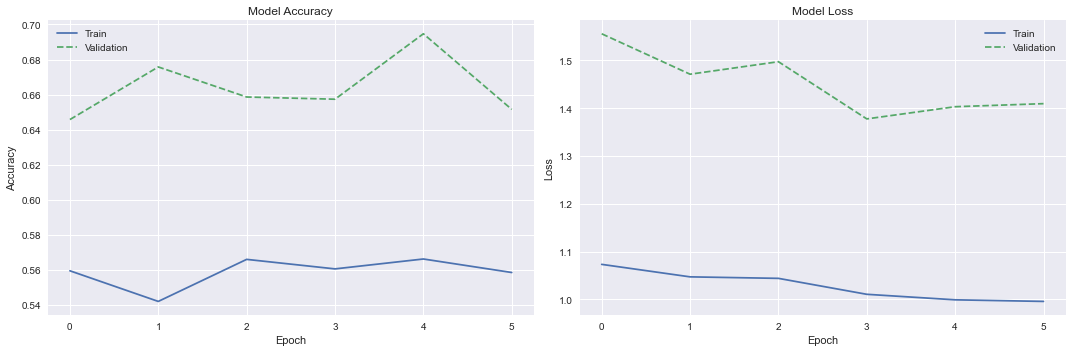

11/11 [==============================] - 14s 1s/step - loss: 1.1214 - accuracy: 0.7182

Final Test Results:
Test Loss: 1.1214
Test Accuracy: 0.7182


In [8]:
# Visualization
plt.style.use('seaborn')
fig = plt.figure(figsize=(15, 5))

# Plot 1: Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation', linestyle='--')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot 2: Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation', linestyle='--')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate on test set
test_dataset = test_dataset.batch(BATCH_SIZE)
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'\nFinal Test Results:')
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')